# COVID-19 SIR Bayesian Model

The [succeptible, infectious, recovered (SIR) model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) is a basic, logistic-like epidemic model. It is called a _compartmental_ model because it assumes that all people divided into a "compartment" have the same parameters.

The tricky part is attempting to mould this model, which is set of ordiary differential equations (ODE), as opposed to an equation, into `pymc3`.

This was inspired by Thomas Wiecki: https://www.youtube.com/watch?v=C1kWBTj6KvE

## The SIR Model

The basic SIR model (without vital dynamics) is formulated in the following way:

$$
\frac{dS}{dt} = - \frac{\beta I S}{N}
$$

$$
\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I
$$

$$
\frac{dR}{dt} = \gamma I
$$

Where S is number of people susceptible, I is the number of people infected, R is the number of people recovered, and N is the sum of these three.

Below you can see an implementation of this in a function, which I will use for plotting and in the model.

In [0]:
def sir_model(y, t, p): # The signature of this function is expected in this slightly strange format see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
  S = y[0] # We have to index parameters like this because inside Theano this is some
  I = y[1] # kind of crazy compiled function. You can't use the S, I, R, 𝛽 = y syntax.
  R = y[2]

  𝛽 = p[0]
  𝛾 = p[1]
  N = p[2]

  new_infections = 𝛽 * I * S / N # Be careful here. Very easy to get negative people. We shouldn't have more infections than the number of people.
  recoveries = 𝛾 * I

  dS = -new_infections
  dI = new_infections - recoveries
  dR = recoveries

  return [dS, dI, dR]

Like last time, I find it useful to plot this model to see how it behaves.

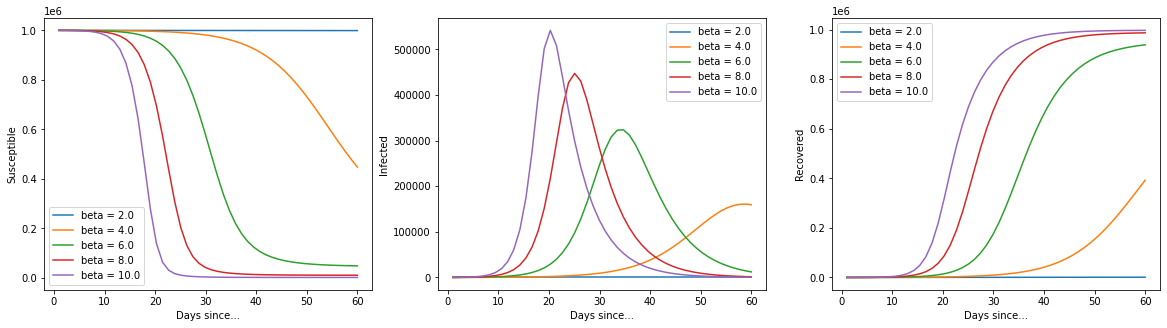

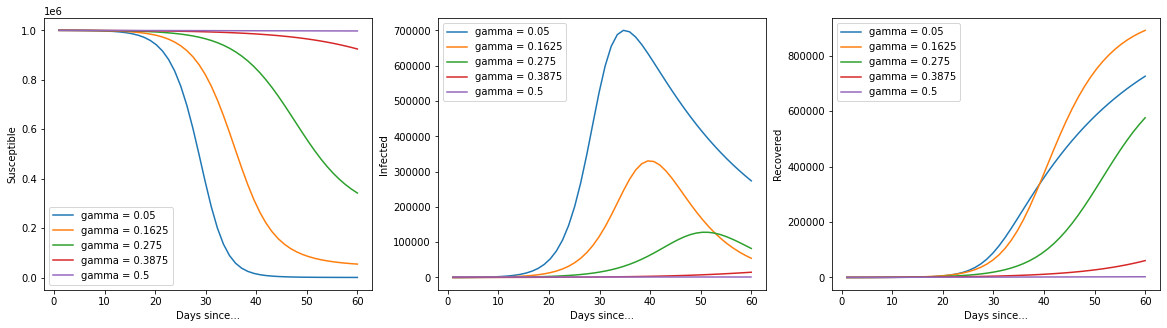

In [260]:
import numpy as np
import matplotlib.pyplot as plt

y = np.array((10e5 - 100, 100, 0)) # S_0, I_0, R_0
p = np.array((5, 0.2, 10e6)) # 𝛽, 𝛾, N
ts = np.linspace(1,60)

def generate_data(y, p, ts):
  res = []
  for t in ts:
    y_next = sir_model(y, t, p)
    y = y + y_next
    res.append(y)
  return np.array(res)

# plt.plot(ts, generate_data(y, p, ts))
# plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for 𝛽 in np.linspace(2, 10, 5):
  p = np.array((𝛽, p[1], p[2])) # 𝛽, 𝛾, N
  res = generate_data(y, p, ts)
  for i in range(3):
    ax[i].plot(ts, res[:,i], label=f"beta = {𝛽}")
    ax[i].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Susceptible")
ax[1].set(xlabel="Days since...", ylabel="Infected")
ax[2].set(xlabel="Days since...", ylabel="Recovered")

y = np.array((10e5 - 100, 100, 0)) # S_0, I_0, R_0
p = np.array((5, 0.2, 10e6)) # 𝛽, 𝛾, N

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for 𝛾 in np.linspace(0.05, 0.5, 5):
  p = np.array((p[0], 𝛾, p[2])) # 𝛽, 𝛾, N
  res = generate_data(y, p, ts)
  for i in range(3):
    ax[i].plot(ts, res[:,i], label=f"gamma = {𝛾}")
    ax[i].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Susceptible")
ax[1].set(xlabel="Days since...", ylabel="Infected")
ax[2].set(xlabel="Days since...", ylabel="Recovered")
plt.show()

So from these plots you can see that 𝛽 controls the maximum number of and/or how quickly people get infected. 𝛾 affects the total number of infections and seems to shift the shape of the peak.

𝛽 / 𝛾 is the number of new infections expected from a single person.

Ok, let's reload the data and try and squeeze this into `pymc3`.

In [47]:
!pip install arviz pymc3==3.8
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano

# Load data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required

country = "China"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2018"] for key in df["country"].unique()}

## SIR Model

In [0]:
# S, I, R, 𝛽 = y
# 𝛾, N = p

def model_factory(country: str, x: np.ndarray, y: np.ndarray):
  with pm.Model() as model:
    sd = pm.HalfNormal('sd', 0.5)
    # 𝛽 = pm.Lognormal('beta',mu=pm.math.log(2),sigma=2) # Check this docs...
    𝛽 = pm.HalfNormal('beta', sd)
    𝛾 = 1/9
    sigma = pm.HalfNormal('sigma', 1)

    # Intercept - We fixed this at 100, but give it a bit of license to fit.
    # S = pm.Normal("S", mu=100, sigma=10)
    S = 100 # Should really train this, but it takes for everrr.

    N = 10e6 # Population
    R_0 = 0 # No initial resisitance
    I_0 = 100 # infection rate at time 0. Should be about 100. Can add a parameter here
    S_0 = S # Initial susceptible
    𝛽_0 = 𝛽 # Initial beta
    𝛾_0 = 𝛾 # Initial gamma

   
    ode = pm.ode.DifferentialEquation(
        func=sir_model,
        times=x,
        n_states=3, # S, I, R
        n_theta=3, # 𝛽, 𝛾, N
        t0=0
    )(
        y0=[S_0, I_0, R_0],
        theta=[𝛽_0, 𝛾_0, N],
        return_sens = False
    )

    

    # I + R - initial_resistance = total cases
    total_cases = ode.T[1] + ode.T[2] - R_0

    # pm.Deterministic(f"S_{country}", ode.T[0])
    # pm.Deterministic(f"I_{country}", ode.T[1])
    # pm.Deterministic(f"R_{country}", ode.T[2])

    
    pm.Lognormal(
        f"{country}_total_cases",
        mu=pm.math.log(total_cases),
        sigma=sigma,
        observed=y
    )

  return model

## Model Testing

Let's train it on some synthetic data to begin with to make sure the model can actually fit it. Someone more experienced wouldn't need to do this!

In [261]:
N = 10e6 # Population
R_0 = 0 # No initial resisitance
I_0 = 100 # infection rate at time 0. Should be about 100. Can add a parameter here
S_0 = N*0.1 - I_0 - R_0 # Initial susceptible
𝛽_0 = 5 # Initial beta
𝛾_0 = 1/9 # Initial gamma

y = np.array((S_0, I_0, R_0)) # S_0, I_0, R_0
p = np.array((𝛽_0, 𝛾_0, N)) # 𝛽, 𝛾, N
t = np.linspace(1,30)
y_synthetic_SIR = generate_data(y, p, t)
y_synthetic = np.cumsum(y_synthetic_SIR[:,2])
plt.plot(t, y_synthetic)
plt.gca().set_yscale("log")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, sd]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]
The number of effective samples is smaller than 25% for some parameters.


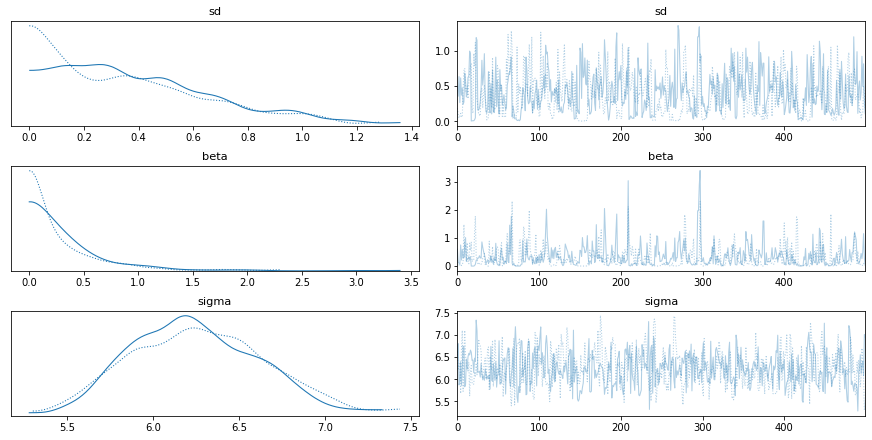

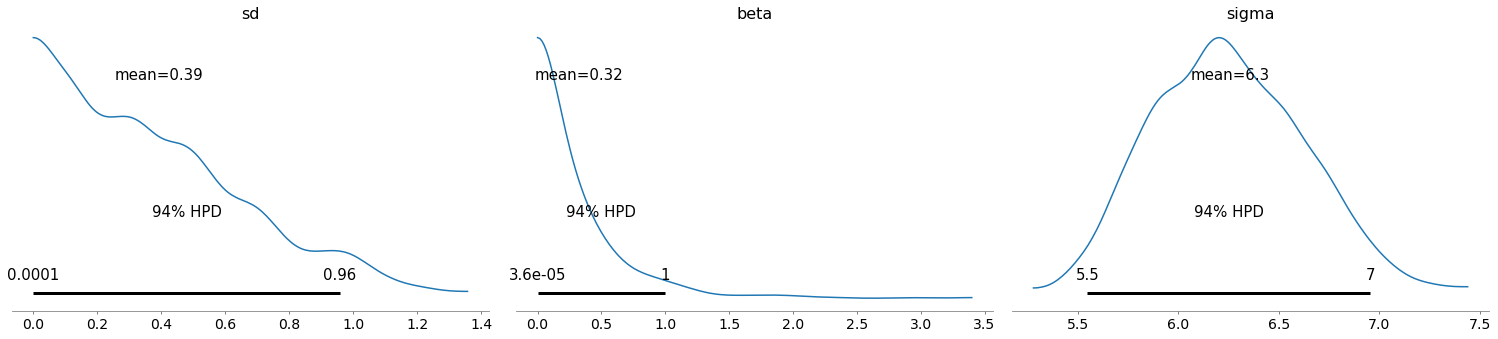

In [266]:
# Training
with model_factory(country, t, y_synthetic) as model:
    train_trace = pm.sample(draws=500, chains=2, target_accept=0.9, cores=1)
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    # ppc = pm.sample_posterior_predictive(train_trace)
    # fig, ax = plt.subplots(figsize=(10, 8))
    # ax.plot(t, ppc[country].T, ".k", alpha=0.05)
    # ax.plot(t, y_synthetic, color="r")
    # ax.set_yscale("log")
    # ax.set(xlabel="Days since 100 cases", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

In [207]:
with model_factory(country, t, y_synthetic) as model:
  # ppc = pm.sample_posterior_predictive(train_trace)
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.plot(t, ppc[f"{country}_total_cases"].T, ".k", alpha=0.05)
  ax.plot(t, y_synthetic, color="r")
  ax.set_yscale("log")
  ax.set(xlabel="Days since 100 cases", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

## China Data

Ok, the above seems to work ok. The K parameter is quite important here. There are a distinct lack of confirmed cases relative to the population.

Let's give it a whirl on real data.

In [0]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]

In [0]:
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

Yep, that looks ok. Let's test. I can't imagine it will be too wrong, since it's practically a straight line now.

In [0]:
# New model with holdout data
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [0]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

In [0]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

## UK Data

Let's try that again with UK data.



In [0]:
country = "United_Kingdom"
# Filter for country (probably want separate models per country, even maybe per region)
sorted_country = df[df["country"] == country].sort_values(by="date")
# Cumulative sum of data
country_cumsum = sorted_country[["cases", "deaths"]].cumsum().set_index(sorted_country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
days_since_100 = range(len(country_cumsum))

# Pull out population size per country
populations = {key: df[df["country"] == key].iloc[0]["popData2018"] for key in df["country"].unique()}

In [0]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]

In [0]:
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")

Yep, that looks ok. Let's test. I can't imagine it will be too wrong, since it's practically a straight line now.

In [0]:
# New model with holdout data
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

In [0]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

In [0]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")